# **Practical Time Series Forecasting with R**
## Chapter 5: Smoothing Methods

In [1]:
# Standard Libraries
import numpy as np
import pandas as pd
from datetime import datetime
from pathlib import Path

# Matplotlib Libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Statsmodels Libraries
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf
from statsmodels.tools.eval_measures import meanabs

# Sklearn Libraries
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Other Libraries
from prophet import Prophet
from tbats import TBATS, BATS


def convert_date(date_str):
    # if the string is 'nan' (which can occur if there was a NaN entry in the original data)
    if date_str == 'nan':
        return None
    # try to parse the date assuming it's in the format 'Dec-00'
    try:
        date = datetime.strptime(date_str, '%b-%y')
        if date.year > datetime.now().year:
            date = date.replace(year=date.year-100) # replace century if needed
    except ValueError:
        # if that fails, assume it's in the format '1-Dec'
        try:
            date = datetime.strptime(date_str, '%d-%b')
            # assuming all dates are in 2000s
            date = date.replace(year=2000 + int(date_str.split('-')[0]))
        except ValueError:
            # if both formats fail, return None or handle as you see fit
            return None
    # convert the date into the desired format
    return date.strftime('%B %Y')

# Define Path
Data_Repo = Path("/Users/[Insert Path to Data]/")

#Data
Amtrak_data = pd.read_csv(Data_Repo / "Amtrak data.csv", skipfooter=96, skip_blank_lines=True, comment='#', engine='python')
Amtrak_data['Month'] = Amtrak_data['Month'].astype(str) # Convert the 'Month' column to string type
Amtrak_data['Month'] = Amtrak_data['Month'].apply(convert_date) # Apply the date conversion function to the 'Month' column

tumblr_data = pd.read_csv(Data_Repo / "Tumblr.csv")
people_ts = tumblr_data['People Worldwide'] / 1000000
bike_hourly_df = pd.read_csv(Data_Repo / "BikeSharingHourly.csv" )
bike_daily_df = pd.read_csv(Data_Repo / "BikeSharingDaily.csv" )  
  

##Ch2 >> Amtrak TimeSeries
ridership_ts = pd.Series(Amtrak_data["Ridership"].values, index=pd.date_range('1991-01', periods=len(Amtrak_data), freq='M'))


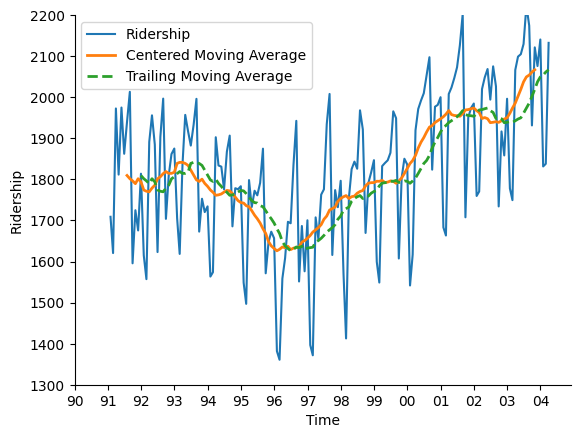

In [3]:
## Figure 5.2: Centered MA & Trailing MA with w = 12
# Calculate moving averages
ma_trailing = ridership_ts.rolling(window=12).mean()
ma_centered = ridership_ts.rolling(window=12, center=True).mean()

# Set up the plot
fig, ax = plt.subplots()

# Plot the data
ax.plot(ridership_ts, label='Ridership')
ax.plot(ma_centered, label='Centered Moving Average', linewidth=2)
ax.plot(ma_trailing, label='Trailing Moving Average', linestyle='--', linewidth=2)

# Set labels, limits, and ticks
ax.set_xlabel('Time')
ax.set_ylabel('Ridership')
ax.set_ylim([1300, 2200])

ax.set_xticks(np.arange('1990', '2005', dtype='datetime64[Y]'))

# Format the x-axis labels as two-digit years
ax.xaxis.set_major_formatter(mdates.DateFormatter('%y'))

# Add legend
ax.legend()

# Remove box (spines)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

# Display the plot
plt.show()

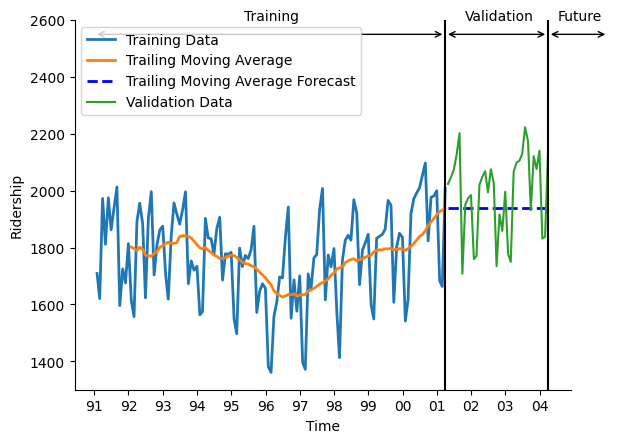

In [4]:
## Figure 5.3: Trailling Moving avg. forecaster with w=12 applied to Amtrak ridership series
# Calculate the number of validation points and training points
n_valid = 36
n_train = len(ridership_ts) - n_valid

# Extract the training and validation time series
train_ts = ridership_ts[:n_train]
valid_ts = ridership_ts[n_train:]

# Calculate the trailing moving average for training data (start 1992)
ma_trailing = train_ts.rolling(window=12, min_periods=1).mean()
ma_trailing = ma_trailing[ma_trailing.index.year >= 1992]

# Get the last value of the trailing moving average
last_ma = ma_trailing[-1]

# Create the trailing moving average forecast for the validation period
ma_trailing_pred = pd.Series([last_ma] * n_valid, index=valid_ts.index)

# Set up the plot
fig, ax = plt.subplots()

# Plot the training data and trailing moving averages
ax.plot(train_ts, label='Training Data', linewidth=2)
ax.plot(ma_trailing, label='Trailing Moving Average', linewidth=2)
ax.plot(ma_trailing_pred, label='Trailing Moving Average Forecast', linewidth=2, linestyle='--', color='blue')
ax.plot(valid_ts, label='Validation Data')

# Adding vertical lines
ax.axvline(train_ts.index[-1], color='black', linestyle='solid')
ax.axvline(valid_ts.index[-1], color='black', linestyle='solid')

# Adding text labels
ax.text(train_ts.index[int(len(train_ts)/2)], 2600, 'Training', horizontalalignment='center')
ax.text(valid_ts.index[int(len(valid_ts)/2)], 2600, 'Validation', horizontalalignment='center')
ax.text(valid_ts.index[-1] + pd.DateOffset(months=11), 2600 , 'Future', horizontalalignment='center')

# Adding arrows
ax.annotate("", xy=(pd.to_datetime('1991-01-01'), 2550), xytext=(train_ts.index[-1], 2550), arrowprops=dict(arrowstyle="<->"))
ax.annotate("", xy=(train_ts.index[-1], 2550), xytext=(valid_ts.index[-1], 2550), arrowprops=dict(arrowstyle="<->"))
ax.annotate("", xy=(valid_ts.index[-1], 2550), xytext=(pd.to_datetime('2006-01-01'), 2550), arrowprops=dict(arrowstyle="<->"))

# Set labels, limits, and ticks
ax.set_xlabel('Time')
ax.set_ylabel('Ridership')
ax.set_ylim([1300, 2600])

# Show Years as 'YY'
years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%y')
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)

# Remove spines
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

# Add legend
ax.legend()

# Display the plot
plt.show()


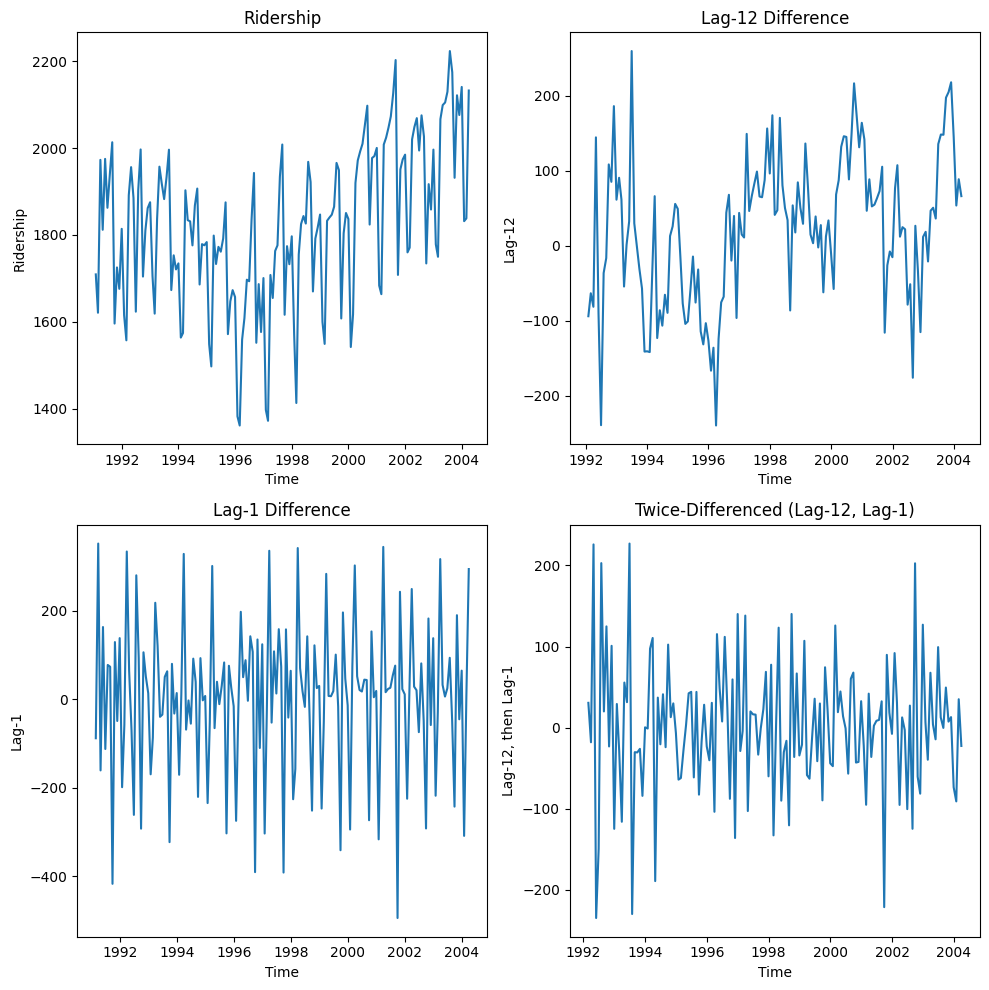

In [5]:
# Figure 5-4: Differencing Amtrak Ridership Series.

# Create a datetime index for the ridership data
start_date = pd.to_datetime('1991-01-01')
end_date = pd.to_datetime('2004-03-01')
dates = pd.date_range(start=start_date, end=end_date, freq='M')

# Create the plots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Ridership plot
axs[0, 0].plot(ridership_ts, label='Ridership')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Ridership')
axs[0, 0].set_title('Ridership')

# Lag-12 difference plot
axs[0, 1].plot(ridership_ts.diff(12), label='Lag-12 Difference')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Lag-12')
axs[0, 1].set_title('Lag-12 Difference')

# Lag-1 difference plot
axs[1, 0].plot(ridership_ts.diff(), label='Lag-1 Difference')  # default lag is 1
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Lag-1')
axs[1, 0].set_title('Lag-1 Difference')

# Twice differenced plot
axs[1, 1].plot(ridership_ts.diff(12).diff(), label='Twice-Differenced (Lag-12, Lag-1)')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Lag-12, then Lag-1')
axs[1, 1].set_title('Twice-Differenced (Lag-12, Lag-1)')

# Display the plots
plt.tight_layout()  # adjusts subplot params so that subplots fit in the figure area
plt.show()


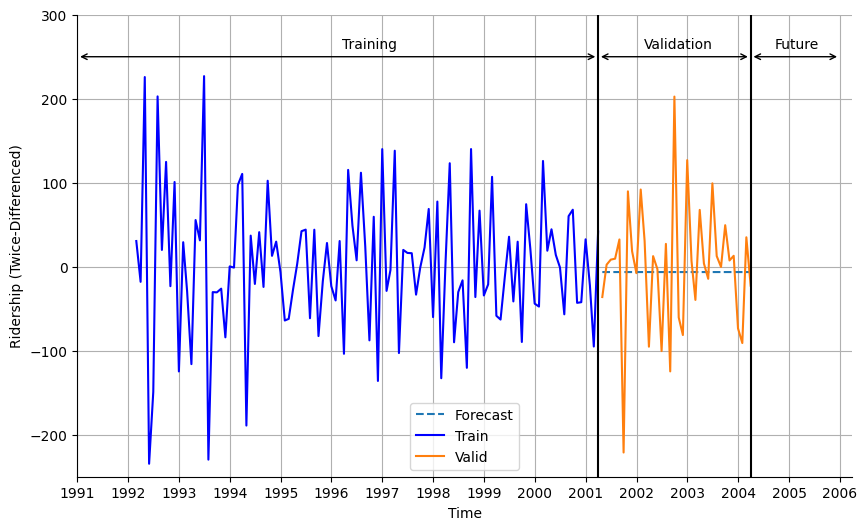

In [6]:
## Figure 5.5: Forcasts simple exponential smoothing with α = 0.2, applied to twice-differenced data (lack trend & seasonality)
# differencing
diff_once_ts = ridership_ts.diff(12).dropna()  # equivalent to diff(ridership.ts, lag = 12)
diff_twice_ts = diff_once_ts.diff(1).dropna()  # equivalent to diff (diff(ridership.ts, lag = 12), lag = 1)

n_valid = 36
n_train = len(diff_twice_ts) - n_valid

# windowing
train_ts = diff_twice_ts.iloc[:n_train] 
valid_ts = diff_twice_ts.iloc[n_train:n_train + n_valid]

# ETS model and forecasting
model = ExponentialSmoothing(train_ts, trend='add', damped_trend=True, seasonal=None).fit(smoothing_level=0.2)
forecast = model.forecast(n_valid)

# plotting
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(forecast.index, forecast, label='Forecast', linestyle='--')
ax.plot(train_ts.index, train_ts, label='Train', color='blue')
ax.plot(valid_ts.index, valid_ts, label='Valid')

# Adding vertical lines
ax.axvline(train_ts.index[-1], color='black', linestyle='solid')
ax.axvline(valid_ts.index[-1], color='black', linestyle='solid')

# Adding text labels
ax.text(train_ts.index[int(len(train_ts)/2)], 260, 'Training', horizontalalignment='center')
ax.text(valid_ts.index[int(len(valid_ts)/2)], 260, 'Validation', horizontalalignment='center')
ax.text(valid_ts.index[-1] + pd.DateOffset(months=11), 260 , 'Future', horizontalalignment='center')

# Adding arrows
ax.annotate("", xy=(pd.to_datetime('1991-01-01'), 250), xytext=(train_ts.index[-1], 250), arrowprops=dict(arrowstyle="<->"))
ax.annotate("", xy=(train_ts.index[-1], 250), xytext=(valid_ts.index[-1], 250), arrowprops=dict(arrowstyle="<->"))
ax.annotate("", xy=(valid_ts.index[-1], 250), xytext=(pd.to_datetime('2006-01-01'), 250), arrowprops=dict(arrowstyle="<->"))

ax.set_ylim(-250, 300)
ax.set_ylabel("Ridership (Twice-Differenced)")
ax.set_xlabel("Time")
ax.set_xlim(pd.to_datetime('1991'), pd.to_datetime('2006-03-31'))  # assuming that dates end at the end of Q1 2006
ax.xaxis.set_major_locator(mdates.YearLocator())  # ticks every year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # format as 'YYYY'

# Removing spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend()
plt.grid(True)
plt.show()



In [7]:
## Table 5.1: Comparision of performance of two simple exponential smoothing models. Optimal is ses.opt
    ## Note: (R) forecast <> (Python) statsmodel; this should be close though

# Simple Exponential Smoothing (no trend, no seasonality) with alpha=0.2
model = ExponentialSmoothing(train_ts, trend=None, seasonal=None).fit(smoothing_level=0.2)
forecast = model.forecast(n_valid)

# Simple Exponential Smoothing with optimal alpha
model_opt = ExponentialSmoothing(train_ts, trend=None, seasonal=None).fit()
forecast_opt = model_opt.forecast(n_valid)

# Computing the accuracy of both models
def compute_accuracy(forecast, actual):
    # Mean absolute error
    mae = np.mean(np.abs(forecast - actual))
    # Mean squared error
    mse = np.mean((forecast - actual)**2)
    # Root mean squared error
    rmse = np.sqrt(mse)
    # Mean absolute percentage error
    mape = np.mean(np.abs((forecast - actual) / actual)) * 100
    # Autocorrelation of the error at lag 1
    acf1 = acf(forecast - actual)[1]
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'MAPE': mape, 'ACF1': acf1}

accuracy = compute_accuracy(forecast, valid_ts)
accuracy_opt = compute_accuracy(forecast_opt, valid_ts)

# Printing the accuracy of both models
print("Model with alpha=0.2:", accuracy)
print("Optimal model:", accuracy_opt)

# Printing the smoothing level (alpha) and other parameters of the optimal model
print("Smoothing level (alpha) of the optimal model:", model_opt.params['smoothing_level'])
print("Parameters of the optimal model:", model_opt.params)


Model with alpha=0.2: {'MAE': 54.88964007453186, 'MSE': 5774.529517861727, 'RMSE': 75.99032515959993, 'MAPE': 178.3105767942034, 'ACF1': -0.3665234580862946}
Optimal model: {'MAE': 53.025898915292274, 'MSE': 5746.966532299889, 'RMSE': 75.80874970806397, 'MAPE': 111.49433495705858, 'ACF1': -0.36652345808629444}
Smoothing level (alpha) of the optimal model: 0.014999244875057494
Parameters of the optimal model: {'smoothing_level': 0.014999244875057494, 'smoothing_trend': nan, 'smoothing_seasonal': nan, 'damping_trend': nan, 'initial_level': 2.539178326493697, 'initial_trend': nan, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


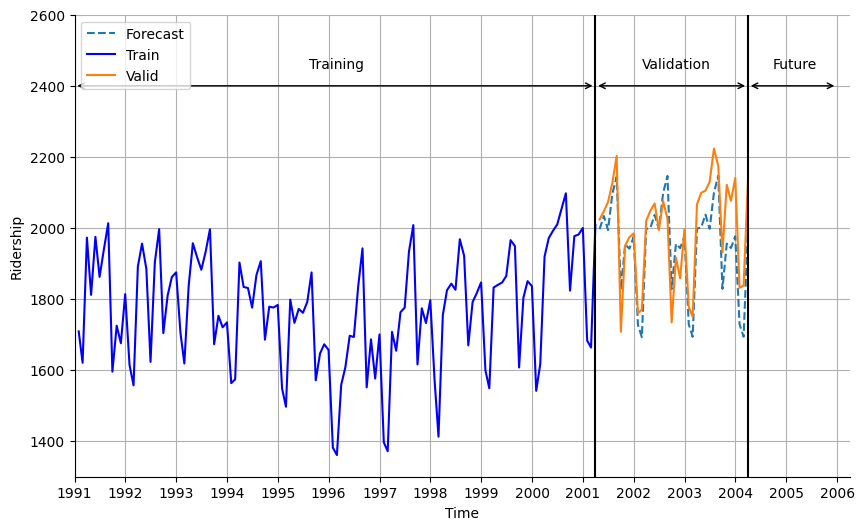

In [8]:
## FIGURE 5.6: Forecast from Holt-Winter's exponential smoothing >> MAA > Multiplicative Error, Additive Trend, Additive Seasonality
from statsmodels.tsa.holtwinters import ExponentialSmoothing

n_valid = 36
n_train = len(ridership_ts) - n_valid

# windowing
train_ts = ridership_ts.iloc[:n_train] 
valid_ts = ridership_ts.iloc[n_train:n_train + n_valid]

# ETS model and forecasting
# model = ExponentialSmoothing(train_ts, trend='add', seasonal='add', seasonal_periods=12).fit()
manual_model = ExponentialSmoothing(train_ts, trend='add', damped_trend=True, seasonal='add', seasonal_periods=12).fit()
forecast = manual_model.forecast(n_valid)

# plotting
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(forecast.index, forecast, label='Forecast', linestyle='--')
ax.plot(train_ts.index, train_ts, label='Train', color='blue')
ax.plot(valid_ts.index, valid_ts, label='Valid')

# Adding vertical lines
ax.axvline(train_ts.index[-1], color='black', linestyle='solid')
ax.axvline(valid_ts.index[-1], color='black', linestyle='solid')

# Adding text labels
ax.text(train_ts.index[int(len(train_ts)/2)], 2450, 'Training', horizontalalignment='center')
ax.text(valid_ts.index[int(len(valid_ts)/2)], 2450, 'Validation', horizontalalignment='center')
ax.text(valid_ts.index[-1] + pd.DateOffset(months=11), 2450 , 'Future', horizontalalignment='center')

# Adding arrows
ax.annotate("", xy=(pd.to_datetime('1991-01-01'), 2400), xytext=(train_ts.index[-1], 2400), arrowprops=dict(arrowstyle="<->"))
ax.annotate("", xy=(train_ts.index[-1], 2400), xytext=(valid_ts.index[-1], 2400), arrowprops=dict(arrowstyle="<->"))
ax.annotate("", xy=(valid_ts.index[-1], 2400), xytext=(pd.to_datetime('2006-01-01'), 2400), arrowprops=dict(arrowstyle="<->"))

ax.set_ylim(1300, 2600)
ax.set_ylabel("Ridership")
ax.set_xlabel("Time")
ax.set_xlim(pd.to_datetime('1991'), pd.to_datetime('2006-03-31'))  # assuming that dates end at the end of Q1 2006
ax.xaxis.set_major_locator(mdates.YearLocator())  # ticks every year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # format as 'YYYY'

# Removing spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend()
plt.grid(True)
plt.show()


In [9]:
# Table 5.2 (Output not exact match)
print(manual_model.summary())  # model information
print(manual_model.params_formatted)  # model parameters

# Initial and final states
initial_states = manual_model.fittedvalues[0]
final_states = manual_model.fittedvalues[-1]

print("Initial states:")
print(initial_states)
print("Final states:")
print(final_states)

# All states
print("All states:")
print("Levels:", manual_model.level)
print("Seasons:", manual_model.season) 

                       ExponentialSmoothing Model Results                       
Dep. Variable:                     None   No. Observations:                  123
Model:             ExponentialSmoothing   SSE                         400865.455
Optimized:                         True   AIC                           1028.971
Trend:                         Additive   BIC                           1076.778
Seasonal:                      Additive   AICC                          1036.350
Seasonal Periods:                    12   Date:                 Fri, 04 Aug 2023
Box-Cox:                          False   Time:                         10:48:12
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.5808006                alpha                 True
smoothing_trend          

In [12]:
## Table 5.4 (NOT THE SAME - See Below)
    ################################################   
    ## Note: No Direct ETS optimization in Python
        ## This loop will try all combinations of additive and multiplicative trends and seasonality components, as well as different lengths of seasonal periods, and select the model with the lowest AIC.
        ## AIC balances model complexity against goodness-of-fit, so lower values of AIC indicate better fitting models
        ## Depending on your data, it may be beneficial to consider other types of models or other model selection criteria
    ################################################

# define list of configuration
trends = ['add', 'mul', None]
seasonals = ['add', 'mul', None]
seasonal_periods = [6, 12]  # adjust this to your data

best_aic = float('inf')
best_config = None
best_model = None

for trend in trends:
    for seasonal in seasonals:
        for period in seasonal_periods:
            try:
                model = ExponentialSmoothing(train_ts, trend=trend, seasonal=seasonal, 
                                             seasonal_periods=period).fit()
                aic = model.aic
                if aic < best_aic:
                    best_aic = aic
                    best_config = (trend, seasonal, period)
                    best_model = model
            except:
                continue  # handle the case where the model cannot be fit

print('Best AIC: %s' % best_aic)
print('Best configuration: %s' % str(best_config))
print('Best model: %s' % best_model.summary())


Best AIC: 1019.4776437246211
Best configuration: (None, 'mul', 12)
Best model:                        ExponentialSmoothing Model Results                       
Dep. Variable:                     None   No. Observations:                  123
Model:             ExponentialSmoothing   SSE                         389639.880
Optimized:                         True   AIC                           1019.478
Trend:                             None   BIC                           1058.848
Seasonal:                Multiplicative   AICC                          1024.610
Seasonal Periods:                    12   Date:                 Fri, 04 Aug 2023
Box-Cox:                          False   Time:                         10:48:51
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level             

In [26]:
## Table 5.5: Comparison of manual and Automated model selection (Note, see Table 5.4 above for automated model)
## Note: Must run fig 5.6 & table 5.4 scripts above

# Make predictions on the validation set
manual_pred = manual_model.predict(start=len(train_ts), end=len(train_ts)+n_valid-1)
auto_pred = best_model.predict(start=len(train_ts), end=len(train_ts)+n_valid-1)

# Retrieve fitted values on the training set
manual_train_pred = manual_model.fittedvalues
auto_train_pred = best_model.fittedvalues

# Naive forecast
naive_forecast = train_ts.shift(1)
mase_denominator = mean_absolute_error(train_ts[1:], naive_forecast[1:])

def compute_metrics(true_values, pred_values):
    me = np.mean(pred_values - true_values)
    rmse = np.sqrt(mean_squared_error(true_values, pred_values))
    mae = mean_absolute_error(true_values, pred_values)
    mpe = np.mean((true_values - pred_values) / true_values) * 100
    mape = np.mean(np.abs((true_values - pred_values) / true_values)) * 100
    mase = meanabs(true_values, pred_values) / mase_denominator
    return {'ME': me, 'RMSE': rmse, 'MAE': mae, 'MPE': mpe, 'MAPE': mape, 'MASE': mase}

# Manual model metrics
metrics_manual_train = compute_metrics(train_ts, manual_train_pred)
metrics_manual_valid = compute_metrics(valid_ts, manual_pred)

# Automated model metrics
metrics_auto_train = compute_metrics(train_ts, auto_train_pred)
metrics_auto_valid = compute_metrics(valid_ts, auto_pred)

# Create DataFrames from the dictionaries
df_manual_train = pd.DataFrame(metrics_manual_train, index=['Manual Train'])
df_manual_valid = pd.DataFrame(metrics_manual_valid, index=['Manual Validation'])
df_auto_train = pd.DataFrame(metrics_auto_train, index=['Automated Train'])
df_auto_valid = pd.DataFrame(metrics_auto_valid, index=['Automated Validation'])

# Concatenate the DataFrames
df = pd.concat([df_manual_train, df_manual_valid, df_auto_train, df_auto_valid])

# Print the DataFrame
print(df.round(4))

                           ME     RMSE      MAE     MPE    MAPE    MASE
Manual Train          -2.0943  57.0883  45.1363  0.0409  2.5723  0.3602
Manual Validation    -43.5080  84.9949  70.4519  2.0854  3.5451  0.5623
Automated Train       -0.4120  56.2832  44.2004 -0.0523  2.5210  0.3528
Automated Validation -45.7833  88.1412  71.7541  2.2311  3.6256  0.5727


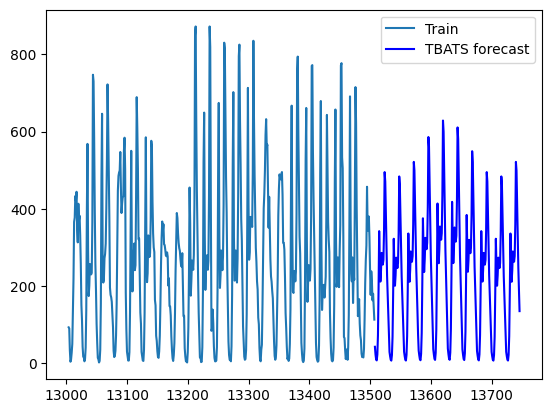

In [27]:
## Figure 5.7 >> Not same as R

# Selecting the data range
selected_data = bike_hourly_df['cnt'][13004:13747]

# Calculating sizes of train and validation sets
nTotal = len(selected_data) # 31 days * 24 hours/day = 744 hours
nTrain = 21 * 24 # 21 days of hourly data
nValid = nTotal - nTrain # 10 days of hourly data

# Splitting data into train and validation sets
yTrain = selected_data[:nTrain]
yValid = selected_data[nTrain:]

###########
## Model 1: Using TBATS to handle multiple seasaonlity (runs longer)
###########
# Create a TBATS estimator
estimator = TBATS(seasonal_periods=(24, 168))

# Fit the model
TBATS_model = estimator.fit(yTrain)

# Make predictions
yForecast = TBATS_model.forecast(steps=len(yValid))

# Plotting the results
plt.plot(yTrain.index, yTrain, label='Train')
plt.plot(yValid.index, yForecast, label='TBATS forecast', color='blue')
plt.legend(loc='best')
plt.show()

# ###########
# ## Model 2: Exponenential Smoothing doesn't handle multiple seasonality
# ###########
# # Fit the model
# es_model = ExponentialSmoothing(yTrain, seasonal_periods=24, trend='add', seasonal='add').fit()

# # Make predictions
# bike_hourly_pred = es_model.predict(start=nTrain, end=nTotal-1)

# # Plotting the results
# plt.plot(yTrain.index, yTrain, label='Train')
# plt.plot(bike_hourly_pred.index, bike_hourly_pred, label='Holt-Winters', color='blue')
# plt.legend(loc='best')
# plt.show()


17:11:09 - cmdstanpy - INFO - Chain [1] start processing
17:11:09 - cmdstanpy - INFO - Chain [1] done processing


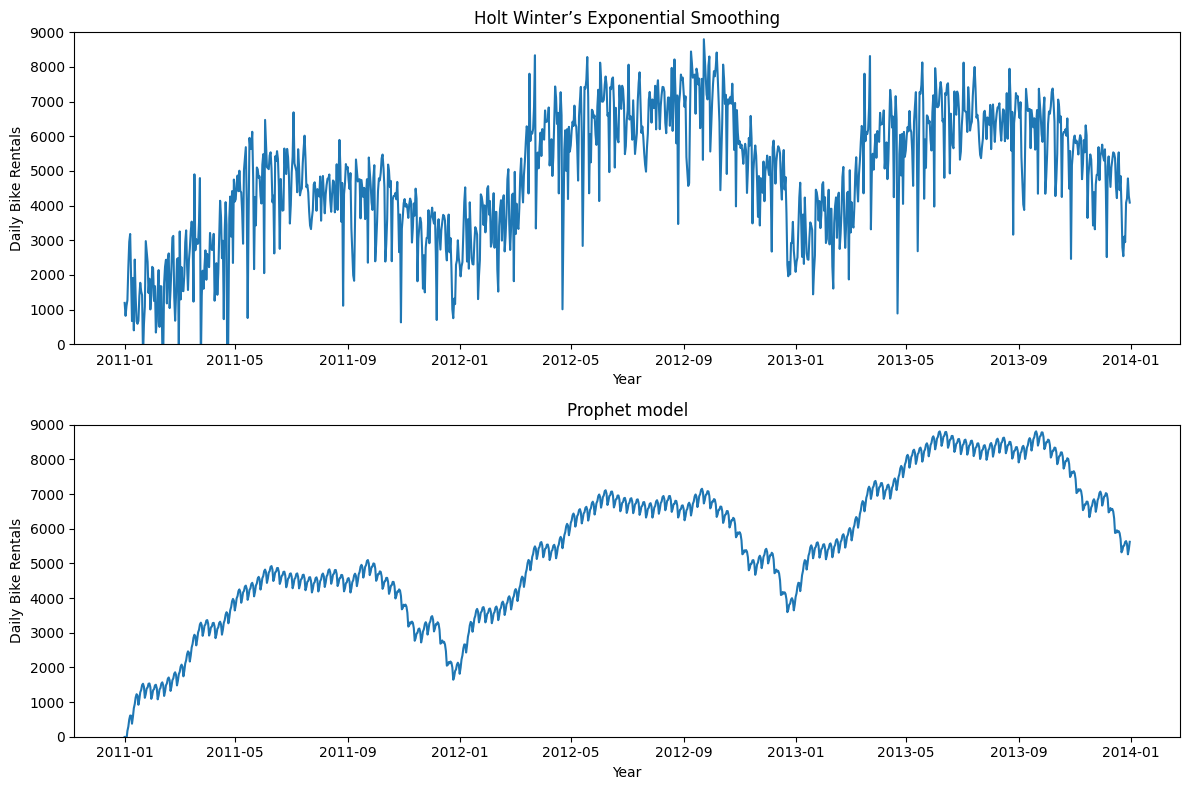

In [38]:
## Figure 5.8 (Not Same As Book >> Exponential smoothing vs. Prophet models)

# Convert the 'dteday' column to a datetime format and set it as index
bike_daily_df['dteday'] = pd.to_datetime(bike_daily_df['dteday'])
bike_daily_df = bike_daily_df.set_index('dteday')

# Create a Prophet model and fit the data
prophet_df = bike_daily_df.reset_index().rename(columns={'dteday': 'ds', 'cnt': 'y'})
m = Prophet(yearly_seasonality=True, weekly_seasonality=True)
m.fit(prophet_df)

# Define the period for which we want a prediction
future = m.make_future_dataframe(periods=365)

# Use the model to make a prediction
forecast = m.predict(future)

# Create a Holt Winter’s Exponential Smoothing model
data = bike_daily_df['cnt']
model = ExponentialSmoothing(data, seasonal_periods=365, trend='add', seasonal='add')
model_fit = model.fit()

# Forecasting
bike_daily_hwes_pred = model_fit.predict(start=data.index[0], end=data.index[-1] + pd.DateOffset(days=365))

# Plots
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# Plot HWES predictions
ax[0].plot(bike_daily_hwes_pred, label='HWES Prediction')
ax[0].set_ylim([0, 9000])
ax[0].set_title('Holt Winter’s Exponential Smoothing')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Daily Bike Rentals')

# Plot Prophet predictions
ax[1].plot(forecast['ds'], forecast['yhat'], label='Prophet Prediction')
# ax[1].fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.1, color='b') ##Uncomment for Forcasting Errors
ax[1].set_ylim([0, 9000])
ax[1].set_title('Prophet model')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Daily Bike Rentals')

plt.tight_layout()
plt.show()
